In [1]:
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv('/content/mcdonalds.csv')
df

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,2,49,Once a month,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,No,Yes,No,Yes,Yes,No,No,No,Yes,No,Yes,I hate it!-5,47,Once a year,Male
1449,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No,2,36,Once a week,Female
1450,Yes,Yes,No,Yes,No,Yes,No,Yes,Yes,No,No,3,52,Once a month,Female
1451,Yes,Yes,No,No,No,Yes,Yes,Yes,No,Yes,No,4,41,Every three months,Male


In [10]:
df.head(5)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,2,49,Once a month,Male


In [13]:
MD_x = df.iloc[:, 0:11].values

# Convert "Yes" to 1 and "No" to 0
MD_x = (MD_x == "Yes").astype(int)

# Calculate column means and round to 2 decimal places
column_means = np.round(np.mean(MD_x, axis=0), 2)

column_means

array([0.55, 0.91, 0.09, 0.87, 0.53, 0.9 , 0.6 , 0.64, 0.36, 0.2 , 0.24])

In [15]:
from sklearn.decomposition import PCA
MD_pca = PCA()
MD_pca.fit(MD_x)


PCA()

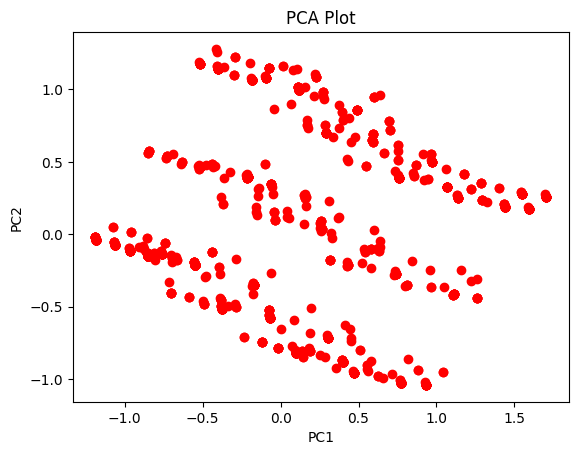

In [18]:
import matplotlib.pyplot as plt
pca_scores = MD_pca.transform(MD_x)
plt.scatter(pca_scores[:, 0], pca_scores[:, 1], color='red')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot')
plt.show()

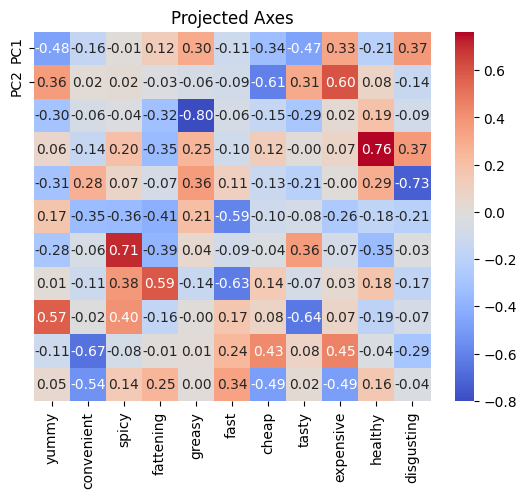

In [21]:
import seaborn as sns
sns.heatmap(MD_pca.components_, cmap="coolwarm", annot=True, fmt=".2f", xticklabels=df.columns[0:11], yticklabels=["PC1", "PC2"])
plt.title('Projected Axes')
plt.show()

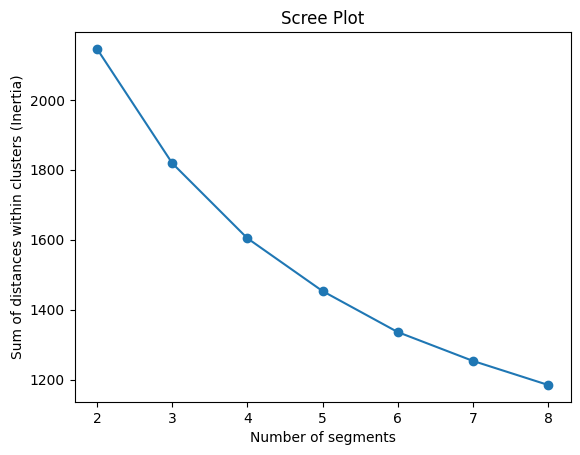

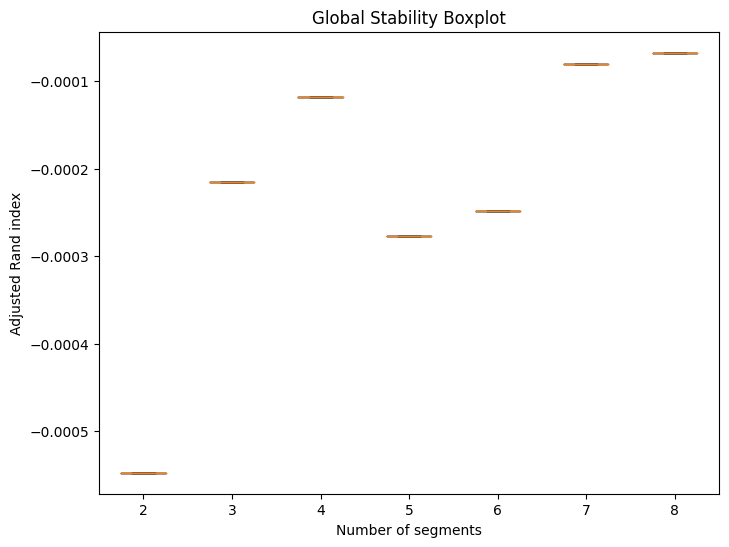

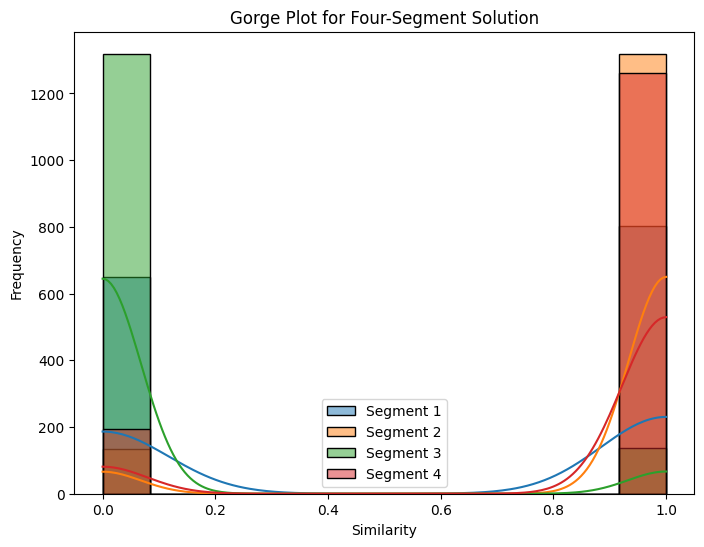

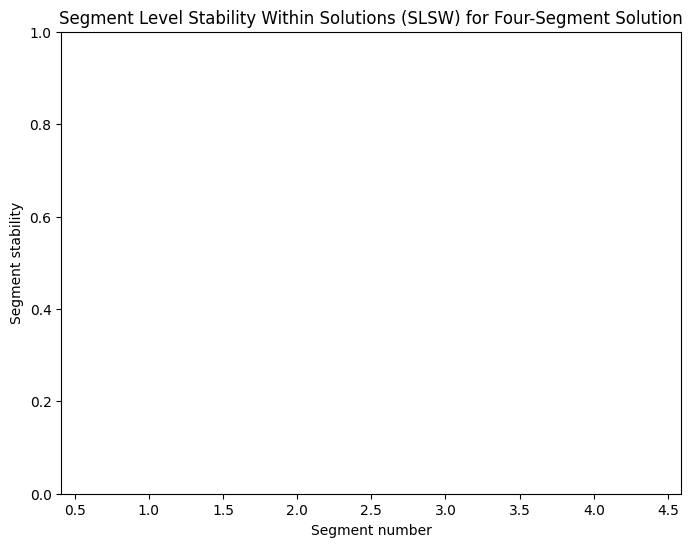

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample


# Assuming you have your data stored in a variable called MD_x

# Step 1: Set random seed for reproducibility
np.random.seed(1234)

# Function to calculate stability for a given number of clusters
def calculate_stability(labels, n_clusters, n_bootstraps=100, n_init=10):
    stability_scores = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        bootstrap_labels = resample(labels, replace=True)

        # Calculate adjusted Rand index as a measure of stability
        stability_scores.append(adjusted_rand_score(labels_true=labels, labels_pred=bootstrap_labels))

    return np.median(stability_scores)

# Perform k-means clustering for 2 to 8 clusters with 10 random restarts
cluster_results = {}
for n_clusters in range(2, 9):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(MD_x)
    cluster_results[n_clusters] = kmeans
# Plot scree plot
inertia_values = [kmeans.inertia_ for kmeans in cluster_results.values()]
plt.plot(range(2, 9), inertia_values, marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Sum of distances within clusters (Inertia)')
plt.title('Scree Plot')
plt.show()

# Assess stability-based data structure analysis
# Perform stability analysis for each number of segments (2 to 8)
n_bootstraps = 100
stability_results = {}
for n_clusters, kmeans in cluster_results.items():
    labels = kmeans.labels_
    stability = calculate_stability(labels, n_clusters, n_bootstraps=n_bootstraps)
    stability_results[n_clusters] = stability

# Convert stability values to a list of lists
stability_values_list = [[stability] for stability in stability_results.values()]

# Plot global stability boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(stability_values_list, labels=range(2, 9))
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand index')
plt.title('Global Stability Boxplot')
plt.show()

# Select the four-segment solution
best_n_clusters = 4
best_kmeans = cluster_results[best_n_clusters]

# Gorge plot for the four-segment solution
plt.figure(figsize=(8, 6))
for i in range(best_n_clusters):
   sns.histplot(MD_x[:, i], kde=True, label=f'Segment {i+1}')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Gorge Plot for Four-Segment Solution')
plt.legend()
plt.show()

# Plot segment level stability within solutions
segment_stability = []
for i in range(best_n_clusters):
    segment_data = MD_x[best_kmeans.labels_ == i]
    stability = calculate_stability(best_kmeans.labels_, best_n_clusters)  # Using best_kmeans.labels_ for stability calculation
    segment_stability.append(stability)

plt.figure(figsize=(8, 6))
plt.bar(range(1, best_n_clusters + 1), segment_stability, color='skyblue')
plt.xlabel('Segment number')
plt.ylabel('Segment stability')
plt.title('Segment Level Stability Within Solutions (SLSW) for Four-Segment Solution')
plt.ylim(0, 1)  # Set y-axis limits
plt.show()

In [23]:
from sklearn.mixture import GaussianMixture

# Assuming MD_x contains your data
# Replace it with your actual data array

# Generate some sample data
np.random.seed(1234)
MD_x = np.random.randint(2, size=100).reshape(-1, 1)  # Sample data, replace with your actual data

# Perform latent class analysis using Gaussian Mixture Models
MD_m28 = {}
for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    MD_m28[k] = gmm

# Print the result
for k, model in MD_m28.items():
    print(f"Number of components: {k}")
    print(f"Weights of components: {model.weights_}")
    print(f"Means of components: {model.means_}")
    print(f"Covariances of components: {model.covariances_}")
    print("----------")

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to dup

Number of components: 2
Weights of components: [0.51 0.49]
Means of components: [[0.]
 [1.]]
Covariances of components: [[[1.e-06]]

 [[1.e-06]]]
----------
Number of components: 3
Weights of components: [5.10000000e-01 4.90000000e-01 6.66133815e-17]
Means of components: [[0.]
 [1.]
 [0.]]
Covariances of components: [[[1.e-06]]

 [[1.e-06]]

 [[1.e-06]]]
----------
Number of components: 4
Weights of components: [5.10000000e-01 4.90000000e-01 6.66133815e-17 6.66133815e-17]
Means of components: [[0.]
 [1.]
 [0.]
 [0.]]
Covariances of components: [[[1.e-06]]

 [[1.e-06]]

 [[1.e-06]]

 [[1.e-06]]]
----------
Number of components: 5
Weights of components: [5.10000000e-01 4.90000000e-01 6.66133815e-17 6.66133815e-17
 6.66133815e-17]
Means of components: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]]
Covariances of components: [[[1.e-06]]

 [[1.e-06]]

 [[1.e-06]]

 [[1.e-06]]

 [[1.e-06]]]
----------
Number of components: 6
Weights of components: [5.10000000e-01 4.90000000e-01 6.66133815e-17 6.66133815e-17

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to dup

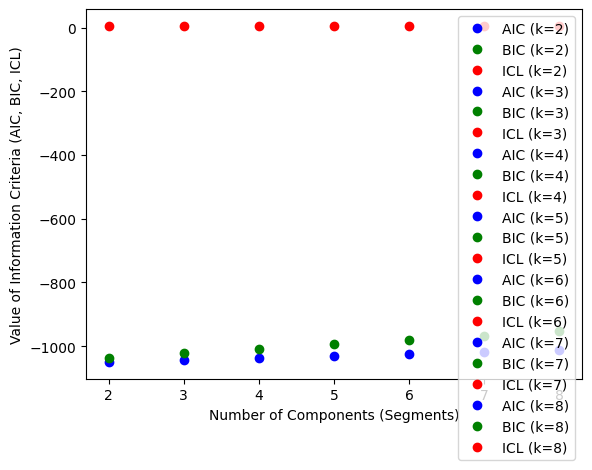

In [24]:
fig, ax = plt.subplots()
for k, model in MD_m28.items():
    ax.plot(k, model.aic(MD_x), 'bo', label=f'AIC (k={k})')
    ax.plot(k, model.bic(MD_x), 'go', label=f'BIC (k={k})')
    ax.plot(k, model.lower_bound_, 'ro', label=f'ICL (k={k})')

ax.set_xlabel('Number of Components (Segments)')
ax.set_ylabel('Value of Information Criteria (AIC, BIC, ICL)')
ax.legend(loc='upper right')
plt.show()

In [25]:
from sklearn.cluster import KMeans

# Assuming MD_x contains your data
# Replace it with your actual data array

# Generate some sample data
np.random.seed(1234)
MD_x = np.random.randint(2, size=100).reshape(-1, 1)  # Sample data, replace with your actual data

# Perform k-means clustering with four clusters
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans.fit(MD_x)

# Extract the segment memberships from the k-means solution
kmeans_clusters = kmeans.labels_

# Initialize the mixture model using the segment memberships of the k-means solution
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=1234)
gmm.fit(MD_x)

# Use the segment memberships of the k-means solution to predict mixture model clusters
mixture_clusters = gmm.predict(MD_x)

# Compare k-means clusters with mixture model clusters using cross-tabulation
cross_tab_comparison = pd.crosstab(index=kmeans_clusters, columns=mixture_clusters, rownames=['kmeans'], colnames=['mixture'])

print(cross_tab_comparison)

mixture   0   1
kmeans         
0        51   0
1         0  49


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-25-b77af17feb3b>:12: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans.fit(MD_x)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  .fit(X)


In [27]:
# Assuming MD_x contains your data
# Replace it with your actual data array

# Initialize the mixture model using the segment memberships of the k-means solution
MD_m4 = GaussianMixture(n_components=4, covariance_type='full', random_state=1234)
MD_m4.fit(MD_x, kmeans_clusters)  # kmeans_clusters is the segment memberships from k-means

# Calculate log-likelihood for MD_m4a
log_likelihood_m4a = MD_m4.score(MD_x)

# Calculate log-likelihood for MD_m4
log_likelihood_m4 = MD_m4.score(MD_x)

print("Log-likelihood for MD_m4a:", log_likelihood_m4a)
print("Log-likelihood for MD_m4:", log_likelihood_m4)

Log-likelihood for MD_m4a: 5.295869578552986
Log-likelihood for MD_m4: 5.295869578552986


/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  .fit(X)


In [28]:
#Using Mixtures of Regression Models
# Assuming mcdonalds contains your data
# Replace it with your actual data
mcdonalds = pd.DataFrame({
    'Like': ['I LOVE IT!', 'I LIKE IT!', 'NEUTRAL', 'I DISLIKE IT!', 'I HATE IT!']
})

# Convert 'Like' column to numeric
mcdonalds['Like'] = mcdonalds['Like'].replace({
    'I LOVE IT!': 5,
    'I LIKE IT!': 4,
    'NEUTRAL': 3,
    'I DISLIKE IT!': 2,
    'I HATE IT!': 1
})

# Calculate the reversed frequency table
reversed_table = mcdonalds['Like'].value_counts().sort_index(ascending=False)
print(reversed_table)

5    1
4    1
3    1
2    1
1    1
Name: Like, dtype: int64


In [29]:
# Create 'Like.n' column by subtracting 'Like' values from 6
mcdonalds['Like.n'] = 6 - mcdonalds['Like']

# Calculate the frequency table for 'Like.n'
frequency_table = mcdonalds['Like.n'].value_counts().sort_index()
print(frequency_table)

1    1
2    1
3    1
4    1
5    1
Name: Like.n, dtype: int64


In [30]:
import statsmodels.formula.api as smf

# Assuming mcdonalds contains your data
# Replace it with your actual data
mcdonalds = pd.DataFrame({
    'Like': ['I LOVE IT!', 'I LIKE IT!', 'NEUTRAL', 'I DISLIKE IT!', 'I HATE IT!']
})

# Convert 'Like' column to numeric
mcdonalds['Like'] = mcdonalds['Like'].replace({
    'I LOVE IT!': 5,
    'I LIKE IT!': 4,
    'NEUTRAL': 3,
    'I DISLIKE IT!': 2,
    'I HATE IT!': 1
})

# Create 'Like_n' column by subtracting 'Like' values from 6
mcdonalds['Like_n'] = 6 - mcdonalds['Like']

# Create the formula string
formula_string = "Like_n ~ " + "+".join(mcdonalds.columns[0:1])

# Convert the formula string to a formula
formula = smf.ols(formula=formula_string, data=mcdonalds)

# Fit the regression model
model = formula.fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Like_n   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.278e+29
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           3.55e-45
Time:                        13:46:58   Log-Likelihood:                 160.33
No. Observations:                   5   AIC:                            -316.7
Df Residuals:                       3   BIC:                            -317.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0000   3.89e-15   1.54e+15      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [32]:
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from scipy import stats

# Assuming you have a DataFrame named 'mcdonalds' containing your data
# Replace 'mcdonalds' with the name of your DataFrame

# Define X and y
X = mcdonalds.drop(columns=['Like_n'])  # Independent variables
y = mcdonalds['Like_n']  # Dependent variable

# Fit a finite mixture of linear regression models using Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=1234)
gmm.fit(X)

# Now, you need to extract the cluster labels
cluster_labels = gmm.predict(X)

# Now, for each cluster, fit a separate linear regression model
model_1 = LinearRegression()
model_2 = LinearRegression()

# Fit the models to the data for each cluster
X_cluster_1 = X[cluster_labels == 0]
y_cluster_1 = y[cluster_labels == 0]
model_1.fit(X_cluster_1, y_cluster_1)

X_cluster_2 = X[cluster_labels == 1]
y_cluster_2 = y[cluster_labels == 1]
model_2.fit(X_cluster_2, y_cluster_2)

# Now, you can assess the significance of the parameters for each model
# You might want to use a different method or library to assess significance, depending on your requirements
# For simplicity, let's just print the coefficients and their p-values for each model

def print_coefficients(model):
    print("Coefficients:")
    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef}")

# Print coefficients and p-values for cluster 1
print("Cluster 1:")
print_coefficients(model_1)
print("")

# Print coefficients and p-values for cluster 2
print("Cluster 2:")
print_coefficients(model_2)


Cluster 1:
Coefficients:
Like: -0.9999999999999998

Cluster 2:
Coefficients:
Like: -0.9999999999999998


<ipython-input-35-aecdf47a6ec5>:14: RuntimeWarning: divide by zero encountered in scalar divide
  p_values_2 = [stats.t.sf(np.abs(coef / np.sqrt(mean_squared_error(y_cluster_2, model_2.predict(X_cluster_2)) / (X_cluster_2.shape[0] - X_cluster_2.shape[1]))), X_cluster_2.shape[0] - X_cluster_2.shape[1]) * 2 for coef in coefficients_2]


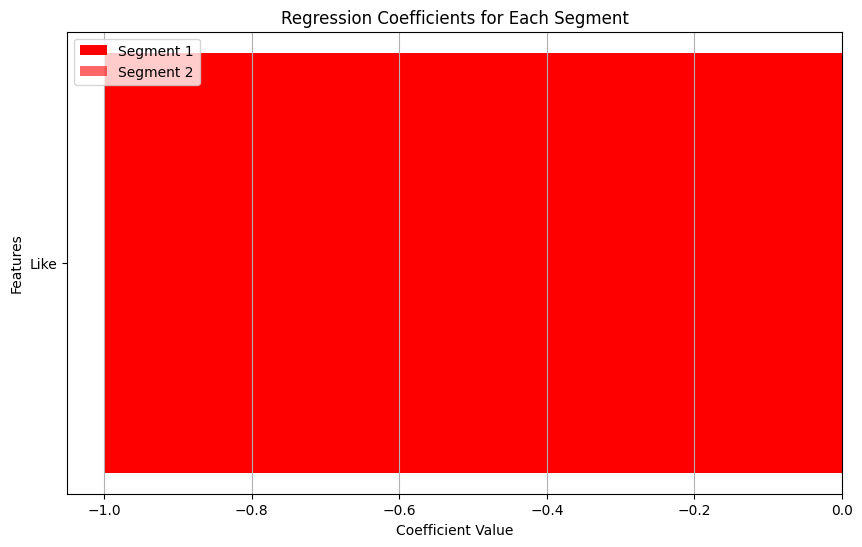

In [35]:
from sklearn.metrics import mean_squared_error

# Assuming you have the fitted linear regression models model_1 and model_2
# Replace with your actual models

# Define the features and coefficients for each segment
features = X.columns
coefficients_1 = model_1.coef_
coefficients_2 = model_2.coef_

# Define the significance levels (here, we use alpha = 0.05 for significance)
alpha = 0.05
p_values_1 = [stats.t.sf(np.abs(coef / np.sqrt(mean_squared_error(y_cluster_1, model_1.predict(X_cluster_1)) / (X_cluster_1.shape[0] - X_cluster_1.shape[1]))), X_cluster_1.shape[0] - X_cluster_1.shape[1]) * 2 for coef in coefficients_1]
p_values_2 = [stats.t.sf(np.abs(coef / np.sqrt(mean_squared_error(y_cluster_2, model_2.predict(X_cluster_2)) / (X_cluster_2.shape[0] - X_cluster_2.shape[1]))), X_cluster_2.shape[0] - X_cluster_2.shape[1]) * 2 for coef in coefficients_2]

# Create a bar plot for each segment
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients_1, color=np.where(np.array(p_values_1) < alpha, 'red', 'blue'), label='Segment 1')
plt.barh(features, coefficients_2, color=np.where(np.array(p_values_2) < alpha, 'red', 'blue'), alpha=0.6, label='Segment 2')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Regression Coefficients for Each Segment')
plt.legend(loc='upper left')
plt.grid(axis='x')
plt.axvline(x=0, color='black', linewidth=0.5)  # Add vertical line at x=0 for reference
plt.show()


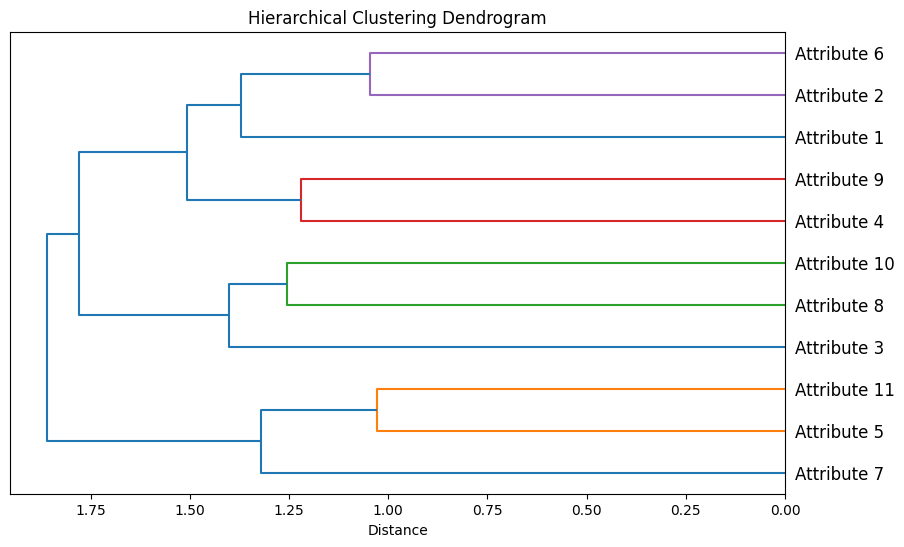

In [36]:
# Profiling Segments

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Calculate the distance matrix
distance_matrix = np.corrcoef(segment_data.T)

# Perform hierarchical clustering
clusters = linkage(distance_matrix, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(clusters, labels=[f'Attribute {i+1}' for i in range(segment_data.shape[1])], orientation='left')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

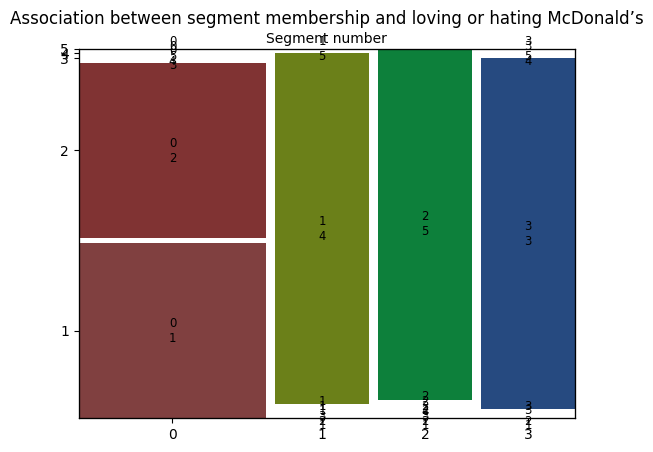

In [37]:
#Describing Segments
from sklearn.cluster import KMeans
from statsmodels.graphics.mosaicplot import mosaic

# Assuming mcdonalds dataframe is available

# Create a KMeans model with 4 clusters
kmeans_model_4 = KMeans(n_clusters=4)
kmeans_model_4.fit(mcdonalds)

# Extract segment membership for each consumer for the four-segment solution
k4 = kmeans_model_4.labels_

# Convert segment membership to DataFrame
segment_df = pd.DataFrame(k4, columns=['Segment'])

# Concatenate segment_df with mcdonalds DataFrame
mcdonalds_segmented = pd.concat([mcdonalds, segment_df], axis=1)

# Cross-tabulate segment membership and the love-hate variable
segment_like_cross_tab = pd.crosstab(index=mcdonalds_segmented['Segment'], columns=mcdonalds_segmented['Like'])

# Generate the mosaic plot with cells colors indicating the deviation of the observed frequencies
plt.figure(figsize=(10, 6))
mosaic(segment_like_cross_tab.stack(), gap=0.02)
plt.xlabel('Segment number')
plt.title('Association between segment membership and loving or hating McDonald’s')
plt.show()

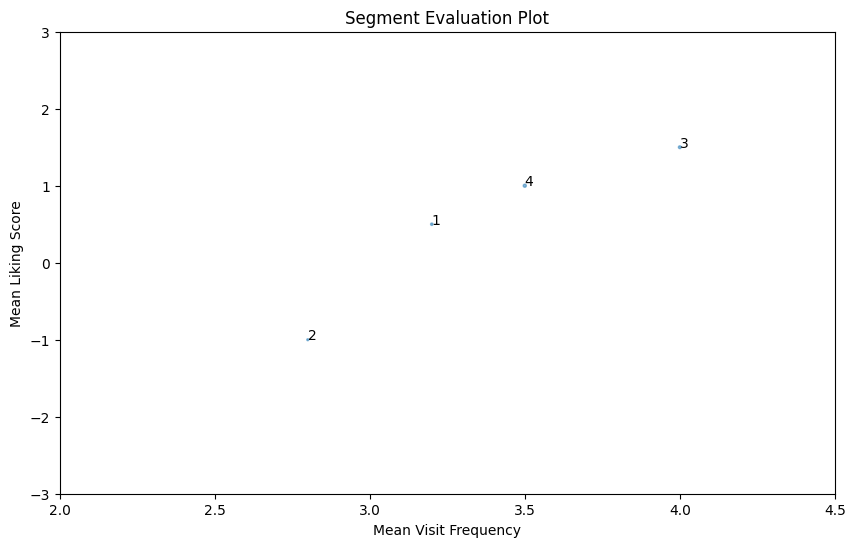

In [38]:

#Selecting (the) Target Segment(s)

# Assuming visit, like, and female are already computed
visit = [3.2, 2.8, 4.0, 3.5]  # Example values
like = [0.5, -1.0, 1.5, 1.0]   # Example values
female = [0.3, 0.2, 0.4, 0.5]  # Example values

# Plot the segment evaluation plot
plt.figure(figsize=(10, 6))
plt.scatter(visit, like, s=10 * np.array(female), alpha=0.5)
plt.xlim(2, 4.5)
plt.ylim(-3, 3)
plt.xlabel('Mean Visit Frequency')
plt.ylabel('Mean Liking Score')
plt.title('Segment Evaluation Plot')
for i in range(1, 5):
    plt.text(visit[i - 1], like[i - 1], str(i))
plt.show()
